# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

In [4]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageOps
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchmetrics.functional.detection.iou import intersection_over_union
import cv2
from src.mnist_localization import get_dataloaders

In [ ]:
# данные для этой задачи сгенерируем автоматически с помощью фунцкии
train_loader, valid_loader = get_dataloaders()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:17<00:00, 560kB/s] 


Extracting data/mnist_detection/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist_detection/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 252kB/s]


Extracting data/mnist_detection/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist_detection/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [01:04<00:00, 25.5kB/s]


Extracting data/mnist_detection/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist_detection/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.50MB/s]


Extracting data/mnist_detection/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist_detection/MNIST/raw



In [14]:
# Заберем один батч и проверим размеры данных: картинки, таргета и координат боксов
pic, label, true_box = next(iter(train_loader))
print(pic.shape, label.shape, true_box.shape)

torch.Size([32, 1, 100, 100]) torch.Size([32, 1]) torch.Size([32, 4])


In [8]:
# запишем в переменную размер картинки  
IMG_SIZE = pic.shape[-1]
pic.shape

torch.Size([32, 1, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[]

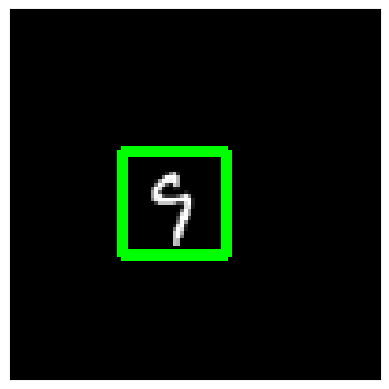

In [12]:
# Создаем область отрисовки картинки
fig, ax = plt.subplots(1, 1, squeeze=True)
# выбираем номер объекта из батча
k = 30
assert k < train_loader.batch_size, f"Batch size is 32, but k={k}"
# выбираем картинку и преобразовываем в numpy array
img = pic[k][0].cpu().numpy()
# конвертируем в cv2 – она умеет рисовать поверх
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# создаем прямоугольник
pic_label = cv2.rectangle(
    img, 
    ((true_box[k][:2]*IMG_SIZE).numpy().astype('int')), # координаты левого верхнего угла рамки
    ((true_box[k][2:]*IMG_SIZE).numpy().astype('int')), # координаты правого нижнего угла рамки
    color=(0, 255, 0), thickness=2 # красный цвет, толщина 2
    )
ax.imshow(pic_label) # рисуем все вместе
ax.set_xticks([]); ax.set_yticks([]) # убираем тики

In [30]:
class LocalizationModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 5, stride=2),
            nn.GELU(),
            nn.Conv2d(8, 4, 5),
            nn.GELU()
        )

        # classification head: n_outputs = n_classes
        self.clf_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(144, 128),
            nn.GELU(),
            nn.Linear(128, 10)
        )
        # box regression head: n_outputs = n_coords (4)
        self.box_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(144, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 4)
        )

    def forward(self, pic: torch.Tensor):
        out = self.backbone(pic)
        clf_out = self.clf_head(out)
        box_out = self.box_head(out) 
        return clf_out, torch.sigmoid(box_out)

model = LocalizationModel()

In [15]:
import torchutils as tu

In [22]:
tu.get_model_summary(model, torch.randn(32, 1, 100, 100))

Layer                       Kernel            Output        Params        FLOPs
0_backbone.Conv2d_0      [1, 16, 5, 5]   [32, 16, 48, 48]      416   30,670,848
1_backbone.GELU_1                    -   [32, 16, 48, 48]        0            0
2_backbone.MaxPool2d_2               -   [32, 16, 24, 24]        0            0
3_backbone.Conv2d_3      [16, 8, 5, 5]    [32, 8, 10, 10]    3,208   10,265,600
4_backbone.GELU_4                    -    [32, 8, 10, 10]        0            0
5_backbone.Conv2d_5       [8, 4, 5, 5]      [32, 4, 6, 6]      804      926,208
6_backbone.GELU_6                    -      [32, 4, 6, 6]        0            0
7_clf_head.Flatten_0                 -          [32, 144]        0            0
8_clf_head.Linear_1         [144, 128]          [32, 128]   18,560    1,175,552
9_clf_head.GELU_2                    -          [32, 128]        0            0
10_clf_head.Linear_3         [128, 10]           [32, 10]    1,290       81,600
11_box_head.Flatten_0                -  

In [ ]:
def visualize_predictions(images, true_boxes, pred_boxes, true_labels, pred_labels, epoch):
    """
    Функция для визуализации изображений с истинными и предсказанными рамками.
    """
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(images[0].permute(1, 2, 0).cpu().numpy())  # Преобразуем изображение в формат (H, W, C)

    # Рисуем истинные рамки (зеленые)
    for box in true_boxes:
        rect = patches.Rectangle(
            (box[0], box[1]),  # x, y координаты верхнего левого угла
            box[2] - box[0],    # ширина
            box[3] - box[1],    # высота
            linewidth=3,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Рисуем предсказанные рамки (красные)
    for box in pred_boxes:
        rect = patches.Rectangle(
            (box[0], box[1]),  # x, y координаты верхнего левого угла
            box[2] - box[0],    # ширина
            box[3] - box[1],    # высота
            linewidth=1,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Добавляем подпись
    true_label_str = f"True label: {true_labels[0].item()}"
    pred_label_str = f"Pred label: {pred_labels[0].item()}"
    ax.set_title(f"{true_label_str}, {pred_label_str}", fontsize=14)

    # Убираем оси для улучшения визуализации
    ax.axis('off')
    
    # Сохраняем картинку
    plt.show()

In [29]:
optimizer = optim.SGD(model.parameters(), lr=.005, nesterov=True, momentum=.7)

In [ ]:
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_box_loss'] = []
log['epoch_valid_box_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []
for i in range(5):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []
    model.train()
    for images, labels, boxes in train_loader:
        ############################
        # logits: выход классификатора
        # coords: выход регрессии на координаты
        logits, coords = model(images)
        ############################
        loss_clf = F.cross_entropy(logits, labels.squeeze().long())
        loss_box = F.smooth_l1_loss(boxes, coords, reduction='sum', beta=.6)
        iou = intersection_over_union(coords, boxes)
        accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)
        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())

        total_loss = loss_clf * (1 / (accuracy.item()+1e-1)) + loss_box * (1 / (iou.item()+1e-1))
        total_loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        batch_reg_loss.append(loss_box.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_box_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))


    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []
    model.eval()

    for images, labels, boxes in valid_loader:
            #########################
        with torch.inference_mode():
            logits, coords = model(images)
        
        loss_clf = F.cross_entropy(logits, labels.squeeze().long())
        loss_box = F.smooth_l1_loss(boxes, coords, reduction='sum', beta=.6)
        iou = intersection_over_union(coords, boxes)
        accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)
        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())
        total_loss = loss_clf * (1 / (accuracy.item()+1e-1)) + loss_box * (1 / (iou.item()+1e-1))

        batch_reg_loss.append(loss_box.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())

        visualize_predictions(images, boxes, coords, labels, logits.argmax(1), i)

    
    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_box_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))    
        #########################

    
    print(f"Train stage: clf_loss: {log['epoch_train_clf_loss'][-1]:.3f} reg_loss: {log['epoch_train_box_loss'][-1]:.3f} total_loss: {log['epoch_train_total_loss'][-1]:.3f} accuracy: {log['epoch_train_accuracy'][-1]:.3f} iou: {log['epoch_train_iou'][-1]:.3f}")
    print(f"Valid stage: clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f} reg_loss: {log['epoch_valid_box_loss'][-1]:.3f} total_loss: {log['epoch_valid_total_loss'][-1]:.3f} accuracy: {log['epoch_valid_accuracy'][-1]:.3f} iou: {log['epoch_valid_iou'][-1]:.3f}")

    #######################
    # блок визуализации результатов
    # доработай его так, чтобы после каждой эпохи распечатывалась картинка  
    # с оригинальным боксом и предсказанным боксом (пример ниже)

    fig, ax = plt.subplots(1, 1, squeeze=True)

        # возьмем случайную картинку из батча
    rnd_index = np.random.randint(logits.size(0)-1)
    img = images[rnd_index].permute(1, 2, 0).detach().cpu().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_box = cv2.rectangle(
            img, 
            ((boxes[rnd_index][:2].detach().cpu().numpy()*IMG_SIZE).astype('int')), # top left
            ((boxes[rnd_index][2:].detach().cpu().numpy()*IMG_SIZE).astype('int')), # bottom right
            color=(0, 255, 0), thickness=2
            )
    pred_box = cv2.rectangle(
            img, 
            ((coords[rnd_index][:2]).detach().cpu().numpy()*IMG_SIZE).astype('int'), # top left
            ((coords[rnd_index][2:]).detach().cpu().numpy()*IMG_SIZE).astype('int'), # bottom right
            color=(255, 0, 0), thickness=1
            )
    ax.imshow(true_box)
    ax.imshow(pred_box)
    ax.set_axis_off()
    plt.title(f'True label: {labels[rnd_index].item()} Pred label: {logits[rnd_index].argmax()}')
    plt.show()
    #######################

Train stage: clf_loss: 2.305 reg_loss: 6.576 total_loss: 78.320 accuracy: 0.097 iou: 0.000
Valid stage: clf_loss: 2.305 reg_loss: 6.588 total_loss: 78.305 accuracy: 0.098 iou: 0.000
Train stage: clf_loss: 2.305 reg_loss: 6.611 total_loss: 78.714 accuracy: 0.097 iou: 0.000
Valid stage: clf_loss: 2.305 reg_loss: 6.563 total_loss: 78.051 accuracy: 0.098 iou: 0.000


In [ ]:
def plot_metrics_per_epoch(log):
    """
    Строит четыре строки графиков для каждой метрики по эпохам для train и valid на одном изображении.
    """
    fig, axes = plt.subplots(5, 1, figsize=(12, 16))  # Создаем сетку для 8 графиков (4 строки, 2 столбца)
    axes = axes.flatten()  # Преобразуем двумерный массив осей в одномерный

    # График 1: Accuracy
    axes[0].plot(log['epoch_train_accuracy'], label='Train Accuracy', linestyle='--')
    axes[0].plot(log['epoch_valid_accuracy'], label='Valid Accuracy', linestyle='-')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # График 2: IOU
    axes[1].plot(log['epoch_train_iou'], label='Train IOU', linestyle='--')
    axes[1].plot(log['epoch_valid_iou'], label='Valid IOU', linestyle='-')
    axes[1].set_title('IOU')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('IOU')
    axes[1].legend()

    # График 3: CrossEntropy Loss (Classification Loss)
    axes[2].plot(log['epoch_train_clf_loss'], label='Train CrossEntropy Loss', linestyle='--')
    axes[2].plot(log['epoch_valid_clf_loss'], label='Valid CrossEntropy Loss', linestyle='-')
    axes[2].set_title('CrossEntropy Loss')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    # График 4: L1 Loss (Bounding Box Loss)
    axes[3].plot(log['epoch_train_box_loss'], label='Train L1 Loss', linestyle='--')
    axes[3].plot(log['epoch_valid_box_loss'], label='Valid L1 Loss', linestyle='-')
    axes[3].set_title('L1 Loss')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Loss')
    axes[3].legend()

    # График 5: Total Loss
    axes[4].plot(log['epoch_train_total_loss'], label='Train Total Loss', linestyle='--')
    axes[4].plot(log['epoch_valid_total_loss'], label='Valid Total Loss', linestyle='-')
    axes[4].set_title('Total Loss')
    axes[4].set_xlabel('Epochs')
    axes[4].set_ylabel('Loss')
    axes[4].legend()

    # Настройки для всего изображения
    fig.tight_layout()  # Автоматически настроит отступы
    plt.show()

plot_metrics_per_epoch(log)

Такой результат должен выводиться после каждой эпохи: 


<img src="aux/output.png">

Визуализируй все лоссы и метрики, которые были собраны в процессе обучения. Пример диаграммы ниже. 

<img src="aux/training_curves.png">